# LC3-RFP-GFP Python Image Analysis Macro

Description

---

## 1. Importing all neccesary packages

In [1]:
import imgfileutils as imf
import customfunctions as cnp
import czifile as zis
import xmltodict
import os
import numpy as np
from matplotlib import pyplot as plt
import napari
from napari.utils import nbscreenshot
from skimage.io import imshow
from skimage import restoration
from skimage.filters import threshold_yen
from skimage.filters import try_all_threshold
from skimage import measure
from scipy import ndimage
import pandas as pd

---

## 2. Opening image and extracting metadata

In [2]:
# choose image file
filename = 'Test.czi'

In [3]:
# get czi object using the filename
czi = zis.CziFile(filename)

# get the metadata and close the czi file object
mdczi = czi.metadata()
czi.close()

# parse the XML into a dictionary
metadatadict_czi = xmltodict.parse(mdczi)

In [4]:
# save metadata as an XML file
xmlczi = imf.writexml_czi(filename)

---

## 3. Exploring metadata

In [5]:
%%capture
array, metadata, add_metadata = imf.get_array_czi(filename, return_addmd=False)

In [6]:
# show all the metadata
for key, value in metadata.items():
    # print all key-value pairs for the metadata dictionary
    print(key, ' : ', value)

Directory  :  
Filename  :  Test.czi
Extension  :  czi
ImageType  :  czi
Name  :  None
AcqDate  :  2022-08-17T06:14:24.672792Z
TotalSeries  :  None
SizeX  :  1024
SizeY  :  1024
SizeZ  :  1
SizeC  :  3
SizeT  :  1
Sizes BF  :  None
DimOrder BF  :  None
DimOrder BF Array  :  None
DimOrder CZI  :  {'B': -1, 'S': -1, 'T': 0, 'C': 1, 'Z': 2, 'Y': 3, 'X': 4, '0': 5}
Axes  :  TCZYX0
Shape  :  (1, 1, 3, 1, 1024, 1024, 1)
isRGB  :  None
ObjNA  :  1.2
ObjMag  :  None
ObjID  :  Objective:1
ObjName  :  C-Apochromat 63x/1.20 W Korr UV VIS IR
ObjImmersion  :  Water
XScale  :  0.099
YScale  :  0.099
ZScale  :  0.099
XScaleUnit  :  µm
YScaleUnit  :  µm
ZScaleUnit  :  None
DetectorModel  :  None
DetectorName  :  None
DetectorID  :  None
InstrumentID  :  None
Channels  :  ['EGFP', 'DAPI', 'mRF12']
ImageIDs  :  []
NumPy.dtype  :  uint8
PixelType  :  Gray8
SizeM  :  1
SizeB  :  1
SizeS  :  1
SW-Name  :  ZEN 2.6 (blue edition)
SW-Version  :  2.6.76.00000
TubelensMag  :  None
ObjNominalMag  :  63.0
Well_Ar

---

## 4. Visualizing images

In [7]:
# visualize in notebook
#ui, out = imf.create_ipyviewer_czi(array, metadata)
#display(ui, out)

In [8]:
# remove unwanted dimensions
array3d = np.squeeze(array)

# visualize in napari
viewer = napari.view_image(
        array3d,
        channel_axis=0,
        name=metadata['Channels'],
        colormap=cnp.dyetocolormap(metadata['Channels']),
        )

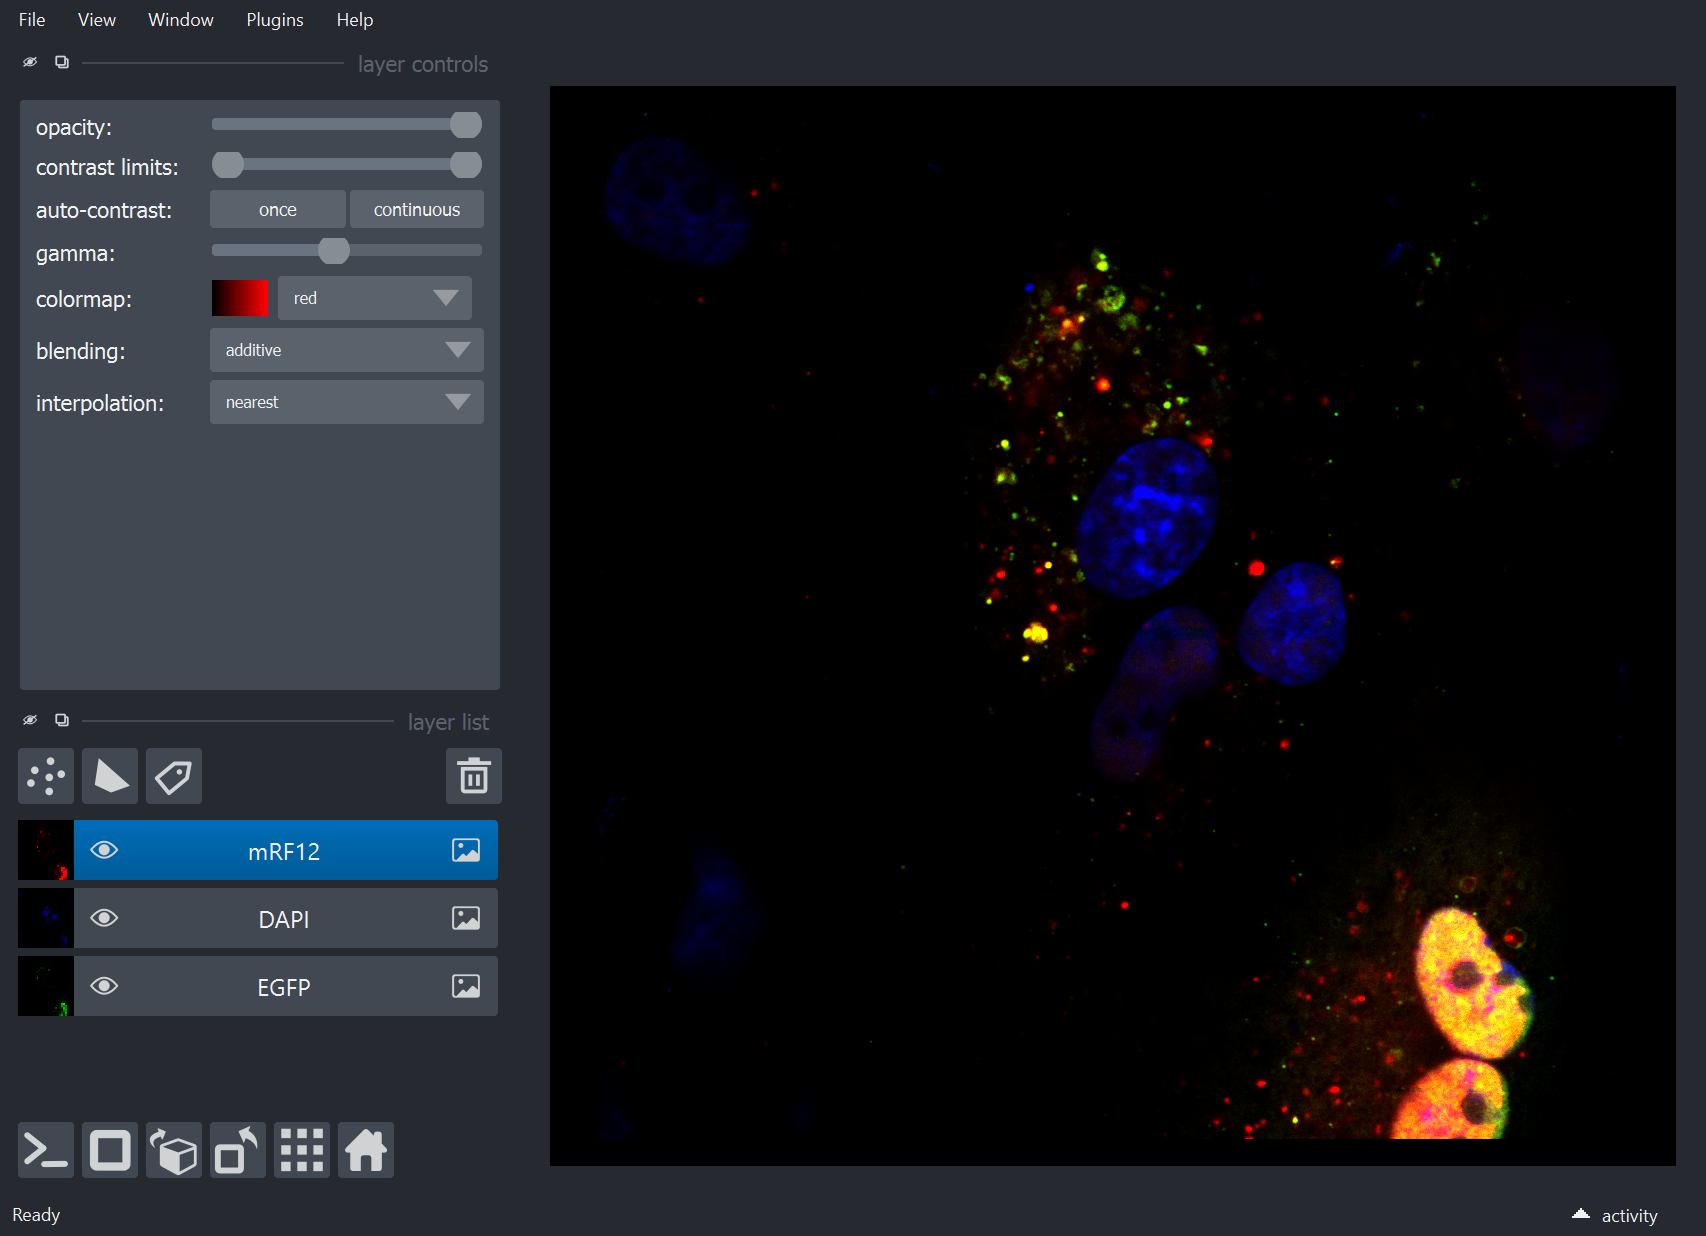

In [9]:
nbscreenshot(viewer)

In [10]:
# split channels
#cnp.splitchannels(array3d)

In [11]:
# split channels
GFP = array3d[0, :, :]
DAPI = array3d[1, :, :]
RFP = array3d[2, :, :]

Text(0.5, 1.0, 'RFP')

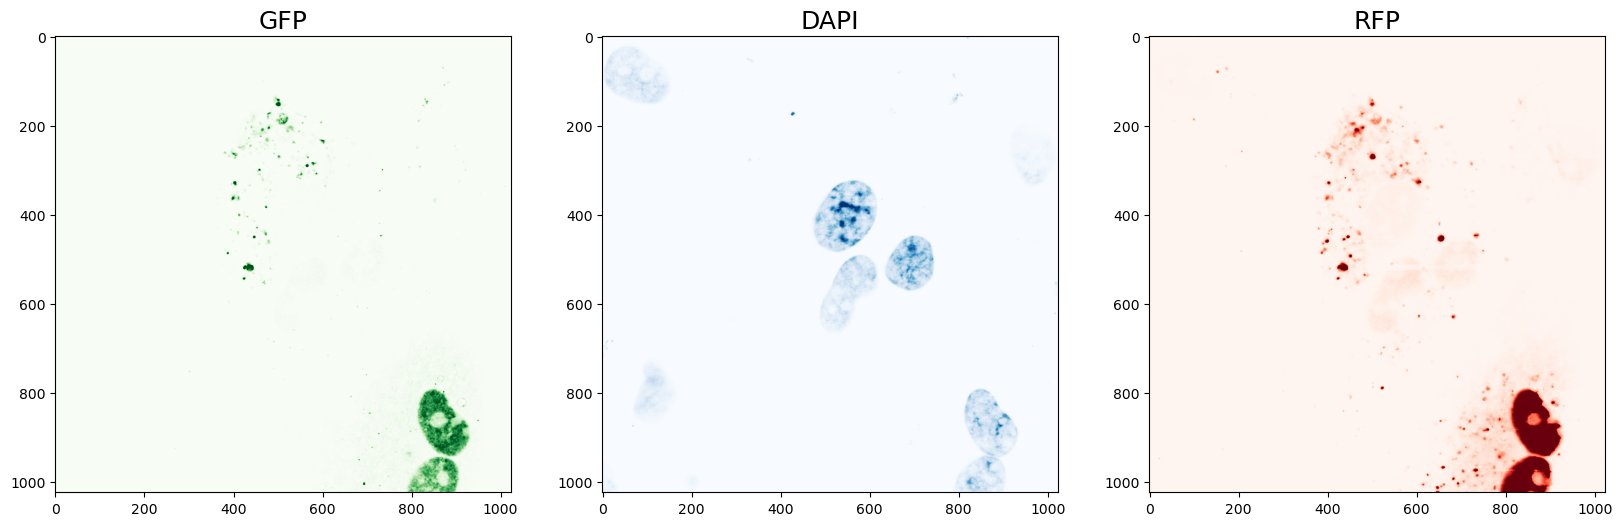

In [12]:
# plot all 3 channels
f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 10))

ax0.imshow(GFP, cmap='Greens')
ax0.set_title('GFP', fontsize=18)

ax1.imshow(DAPI, cmap='Blues')
ax1.set_title('DAPI', fontsize=18)

ax2.imshow(RFP, cmap='Reds')
ax2.set_title('RFP', fontsize=18)

In [13]:
# crop selected area
cropped_array = array3d[:, 100:700, 300:800] 

# visualize in napari
viewer = napari.view_image(
        cropped_array,
        channel_axis=0,
        name=metadata['Channels'],
        colormap=cnp.dyetocolormap(metadata['Channels']),
        )
viewer.layers.remove('DAPI')

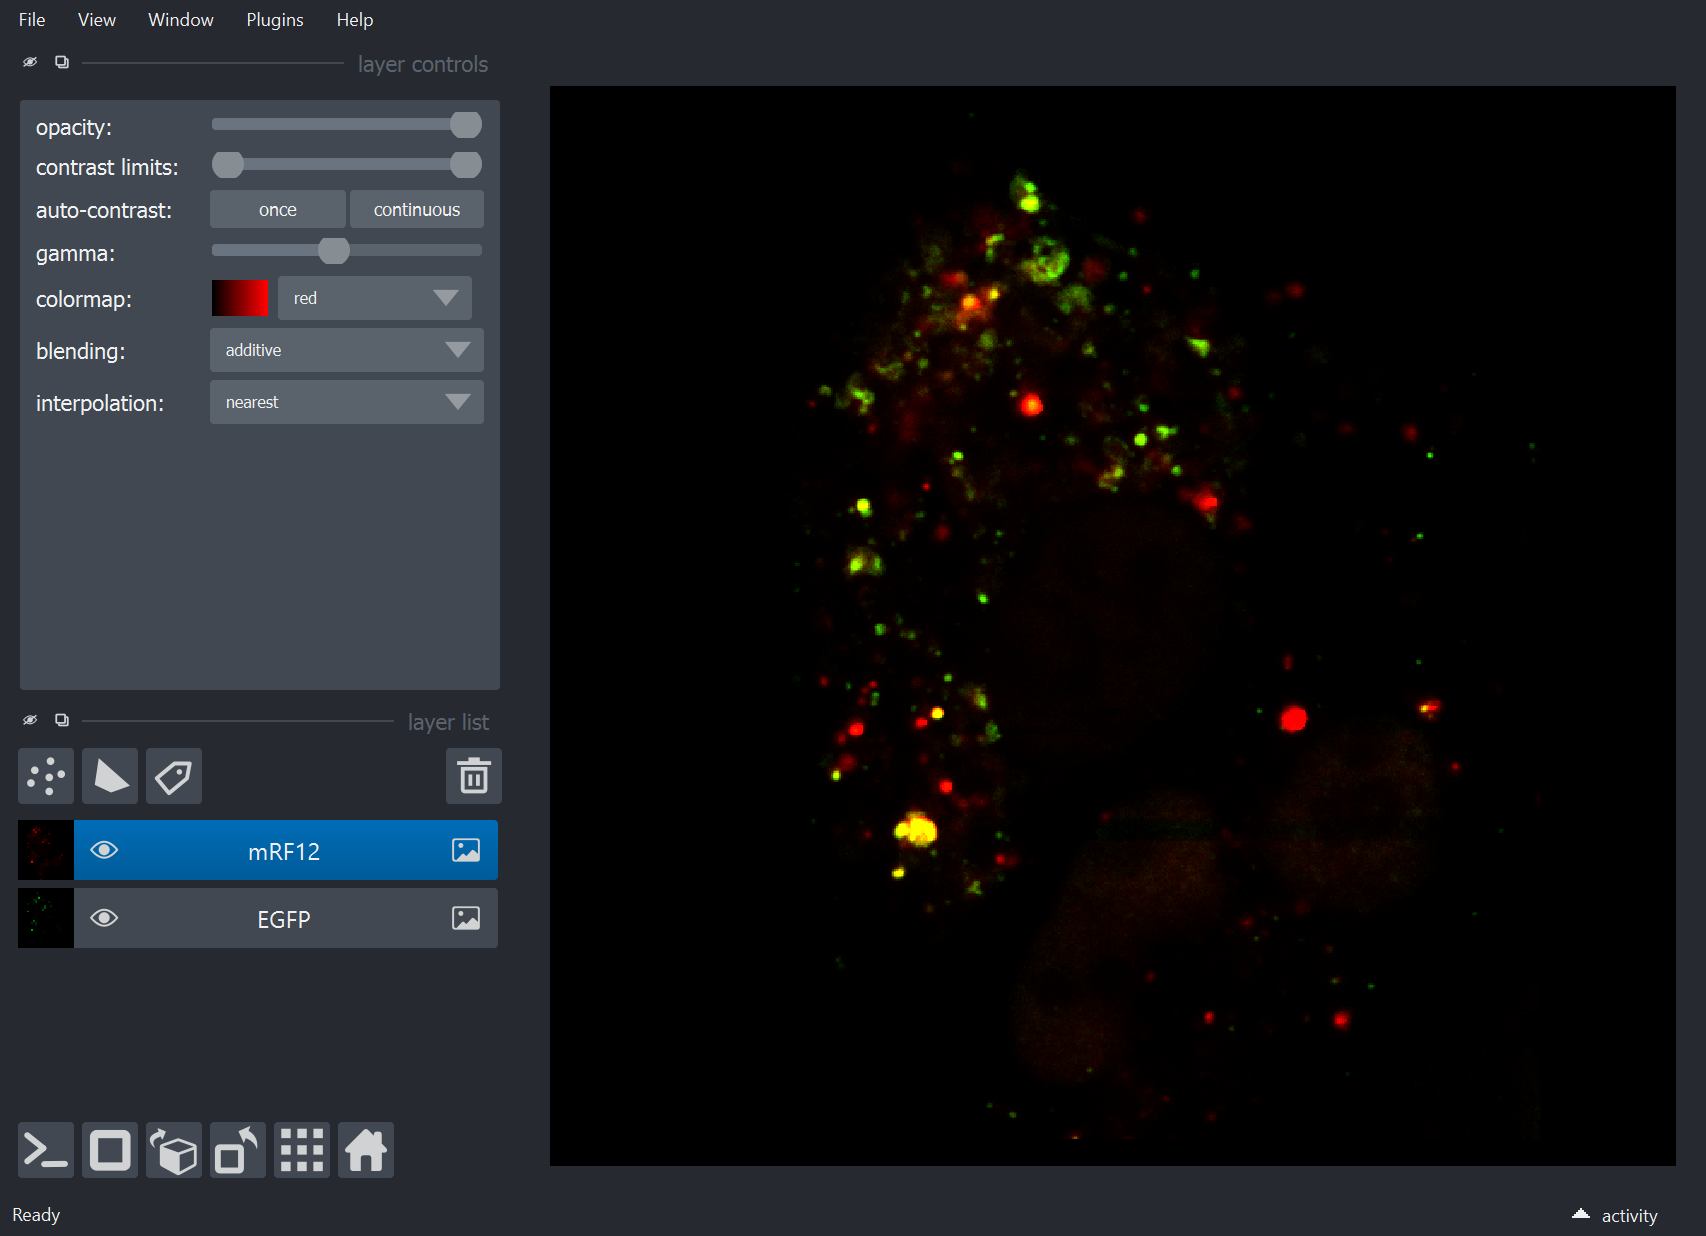

In [14]:
nbscreenshot(viewer)

---

## 5. Preprocessing

In [15]:
# isolate green and red channels
GFPc = cropped_array[0, :, :]
RFPc = cropped_array[2, :, :]

# apply median filter
GFPmed = ndimage.median_filter(GFPc, size=3)
RFPmed = ndimage.median_filter(RFPc, size=3)

# generate and subtract background
GFPbg = restoration.rolling_ball(GFPmed, radius = 10)
GFPbgs = GFPmed - GFPbg

RFPbg = restoration.rolling_ball(RFPmed, radius = 10)
RFPbgs = RFPmed - RFPbg

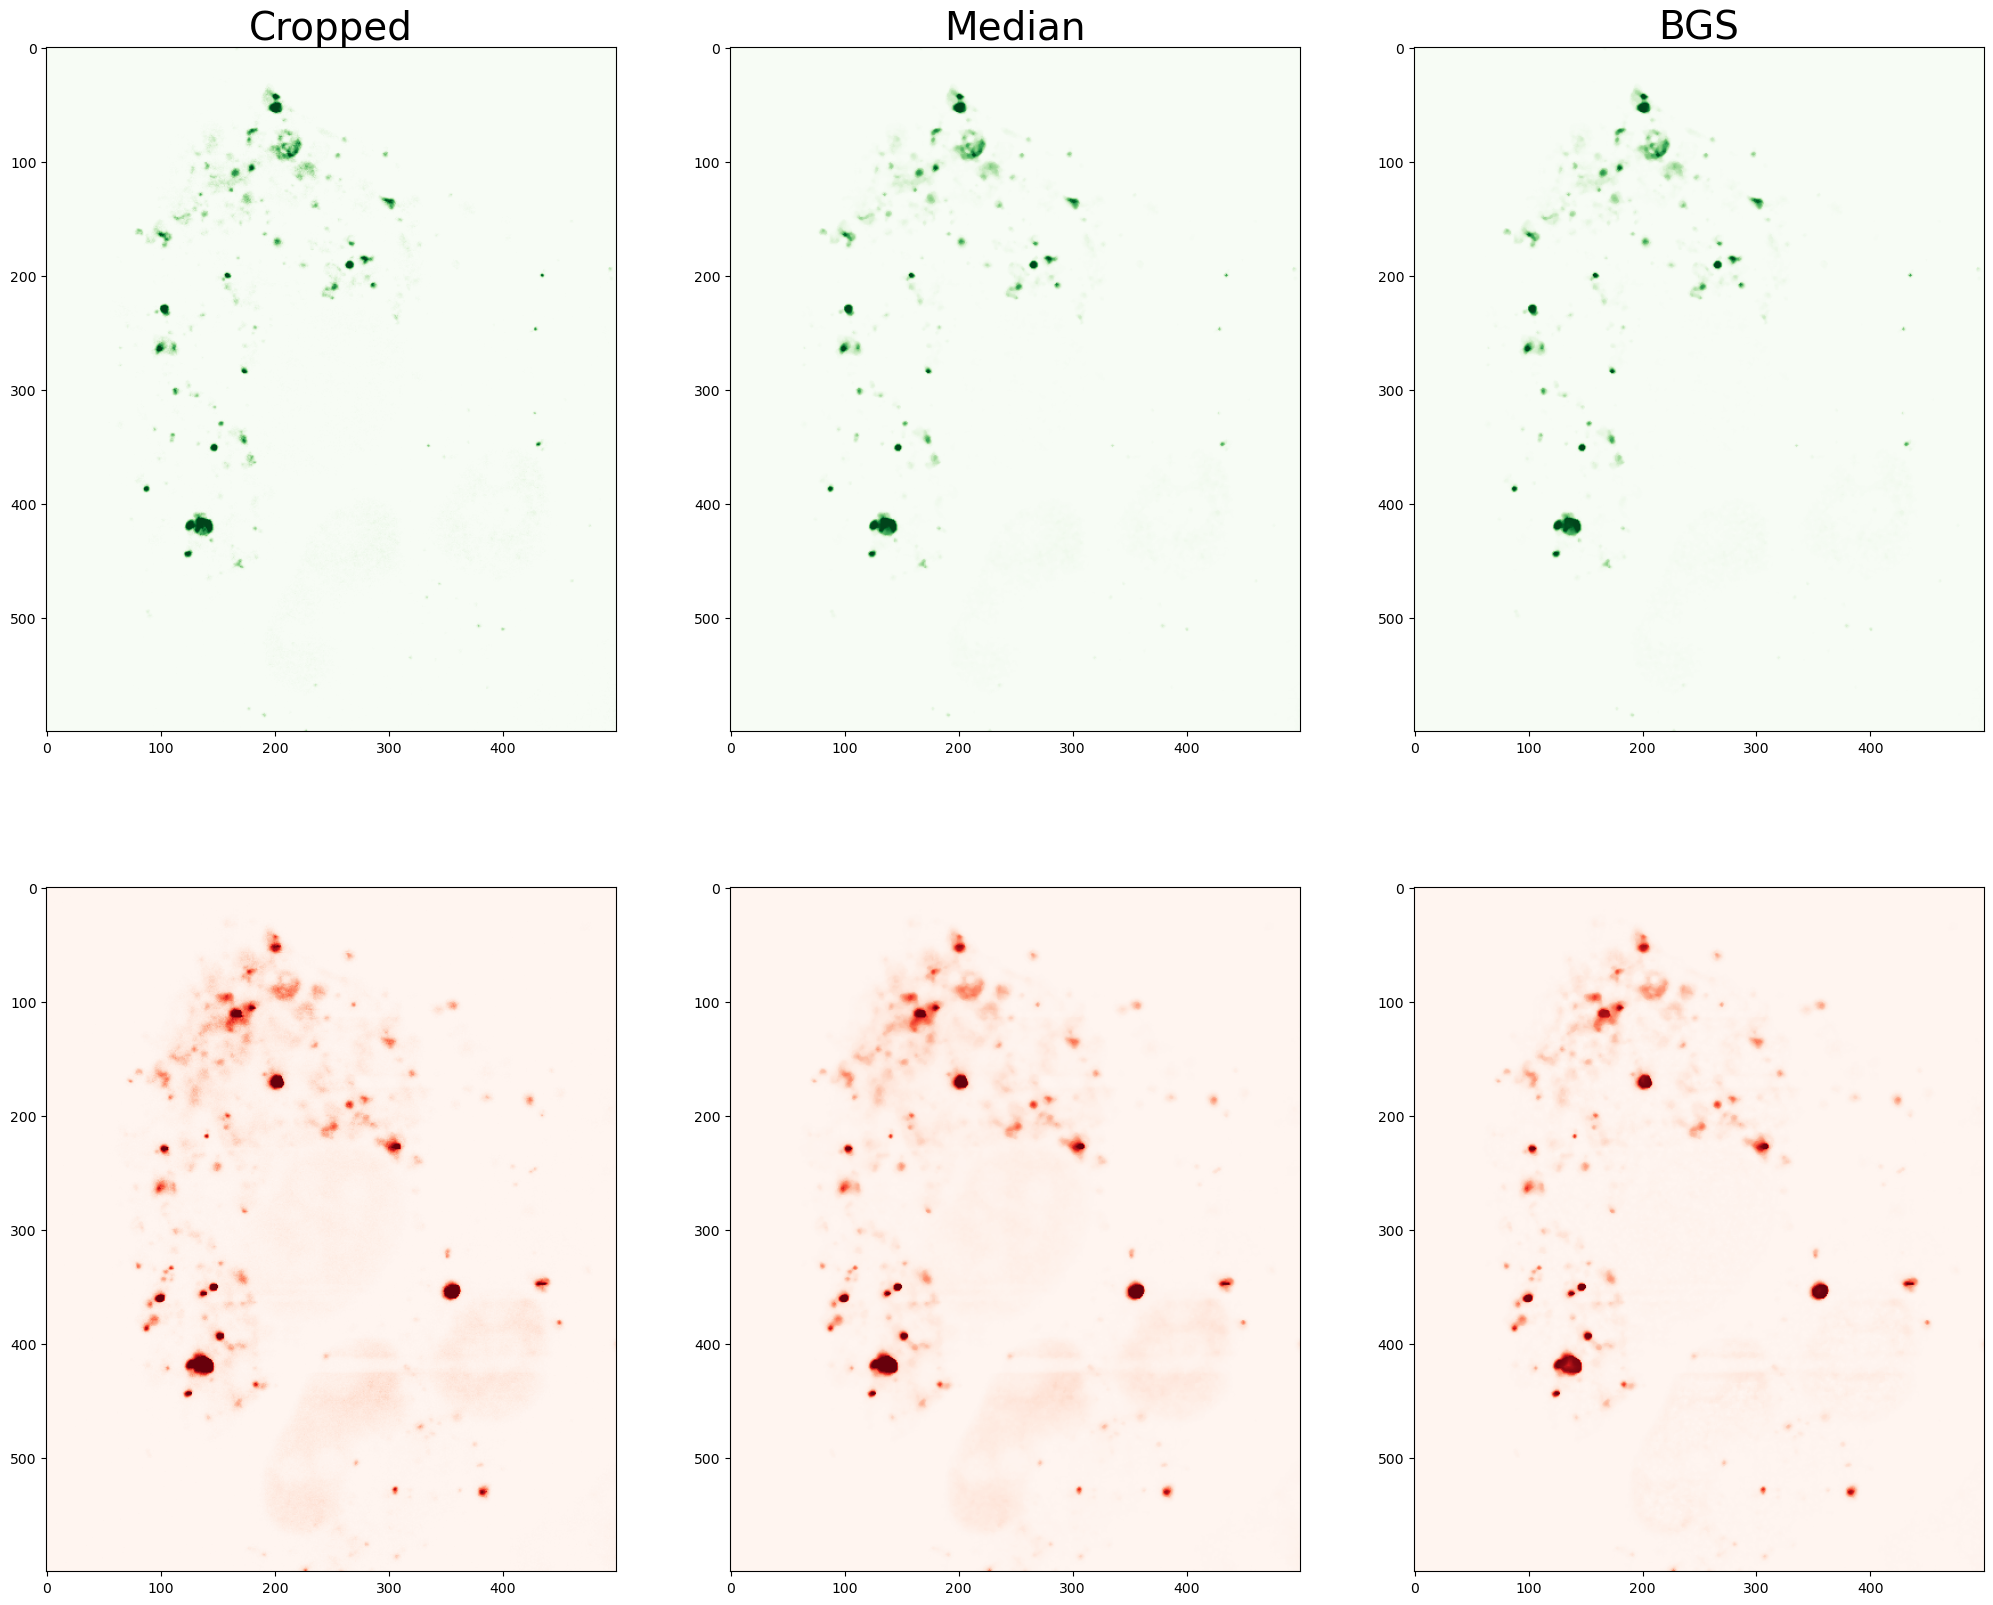

In [16]:
# visualize pipeline
fig, axs = plt.subplots(2, 3, figsize=(25, 20))

axs[0, 0].imshow(GFPc, cmap='Greens')
axs[0, 0].set_title('Cropped', fontsize=28)
axs[0, 1].imshow(GFPmed, cmap='Greens')
axs[0, 1].set_title('Median', fontsize=28)
axs[0, 2].imshow(GFPbgs, cmap='Greens')
axs[0, 2].set_title('BGS', fontsize=28)

axs[1, 0].imshow(RFPc, cmap='Reds')
axs[1, 1].imshow(RFPmed, cmap='Reds')
axs[1, 2].imshow(RFPbgs, cmap='Reds')

---

## 6. Segment puncta

In [17]:
# compare automatic thresholding methods
#try_all_threshold(GFPbgs, figsize = (20,10))

In [18]:
# compare automatic thresholding methods
#try_all_threshold(RFPbgs, figsize = (20,10))

In [19]:
# apply Yen thresholding
GFPbin = GFPbgs > threshold_yen(GFPbgs)
RFPbin = RFPbgs > threshold_yen(RFPbgs)

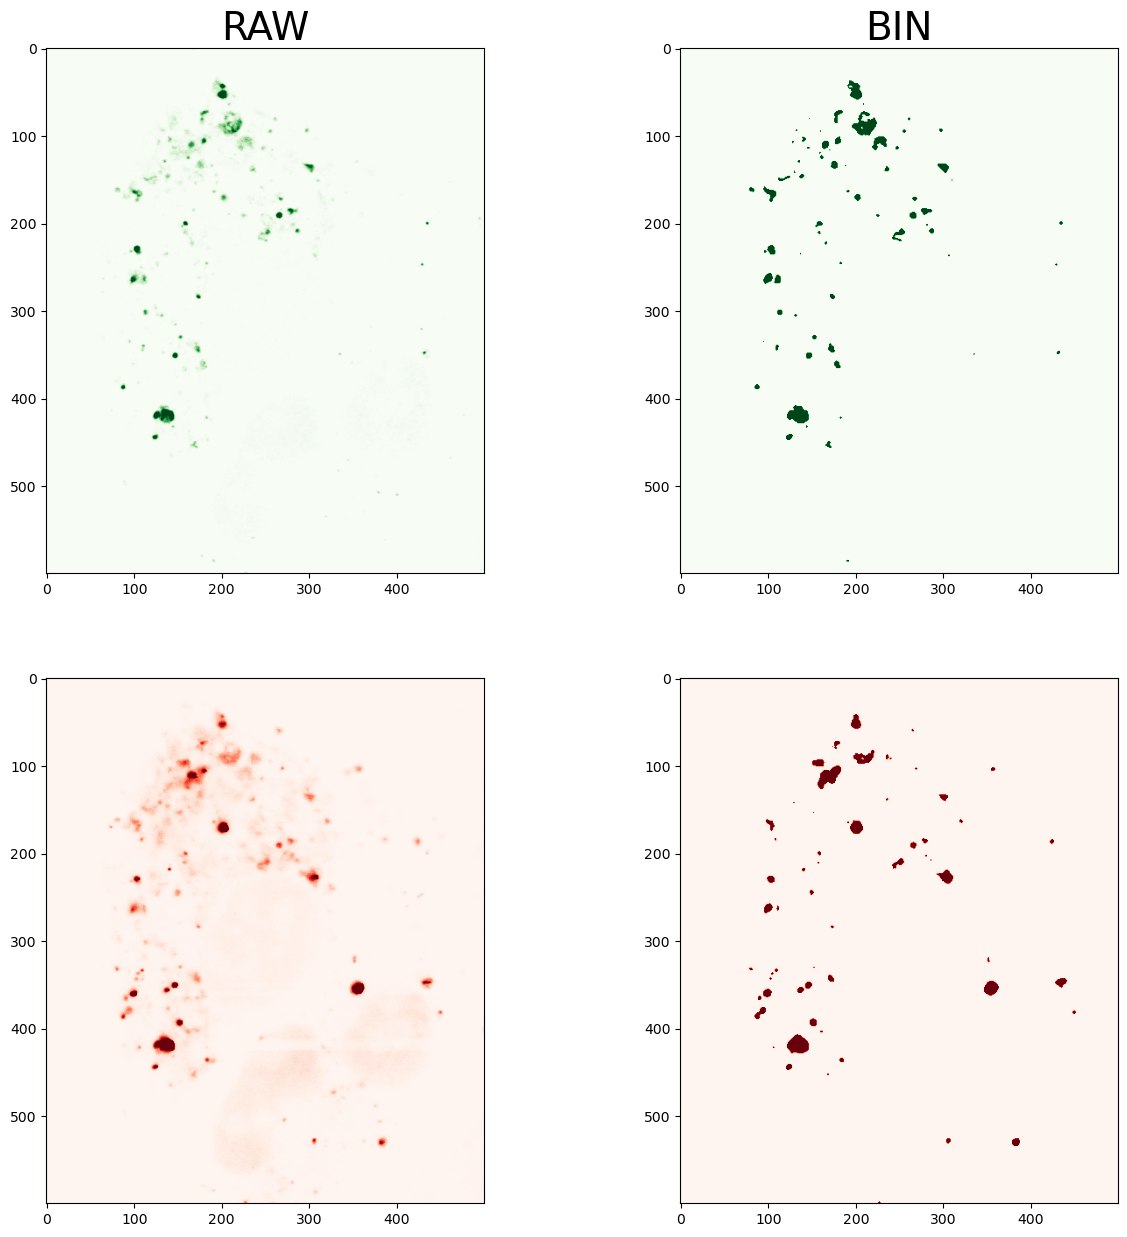

In [20]:
# visualize segmentation
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

axs[0, 0].imshow(GFPc, cmap='Greens')
axs[0, 0].set_title('RAW', fontsize=28)
axs[0, 1].imshow(GFPbin, cmap='Greens')
axs[0, 1].set_title('BIN', fontsize=28)

axs[1, 0].imshow(RFPc, cmap='Reds')
axs[1, 1].imshow(RFPbin, cmap='Reds')

In [21]:
# calculate yellow channel
Ybin = np.logical_and(GFPbin,RFPbin)

---

## 7. Analyze data

In [22]:
# create a list of measurements
measurements = ['label', 'area']

# analyze particles for each channel
GFPlab = measure.label(GFPbin, connectivity=1)
GFPpar = measure.regionprops_table(GFPlab, properties = measurements)

RFPlab = measure.label(RFPbin, connectivity=1)
RFPpar = measure.regionprops_table(RFPlab, properties = measurements)

Ylab = measure.label(Ybin, connectivity=1)
Ypar = measure.regionprops_table(Ylab, properties = measurements)

In [23]:
# summarize data for each channel
GFPdata = pd.DataFrame(GFPpar)
RFPdata = pd.DataFrame(RFPpar)
Ydata = pd.DataFrame(Ypar)

# extract data for each feature
number_of_puncta = [GFPdata.iloc[-1, 0], RFPdata.iloc[-1, 0], Ydata.iloc[-1, 0]]
total_area = [GFPdata.sum()[1], RFPdata.sum()[1], Ydata.sum()[1]]
avg_area = [GFPdata.mean()[1], RFPdata.mean()[1], Ydata.mean()[1]]

In [24]:
# display summary of results
summary = pd.DataFrame({'number_of_puncta':number_of_puncta, 'total_area':total_area, 'avg_area':avg_area}, index = ['GFP', 'RFP', 'Yellow'])
summary

,number_of_puncta,total_area,avg_area
GFP,70,2932,41.885714
RFP,60,3128,52.133333
Yellow,34,1527,44.911765
